In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys

sys.path.insert(0, os.getcwd() + "/../src")
import CAP_utils
import CAP_plots
import CAP_pipeline
import CAP_analysis

from CAP_pipeline import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
test_dir = "/data/data7/network_control/projects/network_control/src"

input_cifti_paths = f"{test_dir}/test_inputs/cifti_paths_file.txt"
dtseries_paths = f"{test_dir}/test_inputs/dtseries.txt"

output_path=f"{test_dir}/outputs/test"

In [5]:

# Test plot outputs
arg_string = f"-c {input_cifti_paths} -o {output_path} -k 3"

# Test ISC thresholding
arg_string = f"-c {input_cifti_paths} -o {output_path} -k 3 -i 0.15"

# Test dscalar plots + write
arg_string = f"-c {input_cifti_paths} -o {output_path} -k 3 -d {dtseries_paths}"

In [6]:
args = CAP_pipeline.get_arguments(arg_string.split(" "))
print("Commandline Args:", args)

Commandline Args: Namespace(ciftis=['/data/data7/network_control/projects/network_control/src/test_inputs/cifti_paths_file.txt'], out_path='/data/data7/network_control/projects/network_control/src/outputs/test', ROI_subset_path=None, isc_threshold=None, dtseries=['/data/data7/network_control/projects/network_control/src/test_inputs/dtseries.txt'], title='test', verbose=1, seed=1, set_k=3, pbar=True)


# Load data

In [7]:
save_paths = create_save_paths(args)
cifti_paths = get_cifti_paths(args.ciftis)

raw_cifti_data_array, ROI_labels = CAP_utils.load_cifti_arrays(cifti_paths, pbar=args.pbar)

preprocess_arguments = {"crop_length": 0} #TODO: Make this into real argparse with specific args
cifti_array = preprocess_cifti_array(raw_cifti_data_array, pbar=args.pbar, **preprocess_arguments)

template_cifti = nb.load(cifti_paths[0])

Loading CIFTIs (ptseries.nii):   0%|          | 0/10 [00:00<?, ?it/s]

Preprocessing CIFTI data array: Done


# ISC Thresholding

In [8]:
if args.isc_threshold:
    ROI_subset, isc_df = ISC_subset(cifti_array, ROI_labels, isc_threshold=args.isc_threshold, pbar=args.pbar)
    CAP_plots.ISC_plot(isc_df, args.isc_threshold, template_cifti, save_path=save_paths["ISC_plot"], title=args.title)
    ROI_subset_values = CAP_utils.cifti_map(ROI_subset, ROI_subset, template_cifti, fill_value="???")
    # TODO: migrate away from SFM???
    sfm.write_labels_to_dlabel(ROI_subset_values, save_paths["ROI_subset_dlabel"],
                               label_name=f"ISC_subset_{args.isc_threshold}")
    # TODO: create and output ISC dscalar
elif args.ROI_subset_path:
    # TODO: Load in ROI subset from given dlabel
    raise NotImplementedError
else:
    ROI_subset = None

# Identify CAP States

In [9]:
CAP_states, CAP_labels = CAP_analysis.find_CAP_states(cifti_array, ROI_labels,
                                                      set_k=args.set_k,
                                                      ROI_subset=ROI_subset,
                                                      seed=args.seed,
                                                      pbar=args.pbar)

Using provided K=3.


# Write CAP_scalar + Make Plots

Writing CAP pscalar.nii: Done 


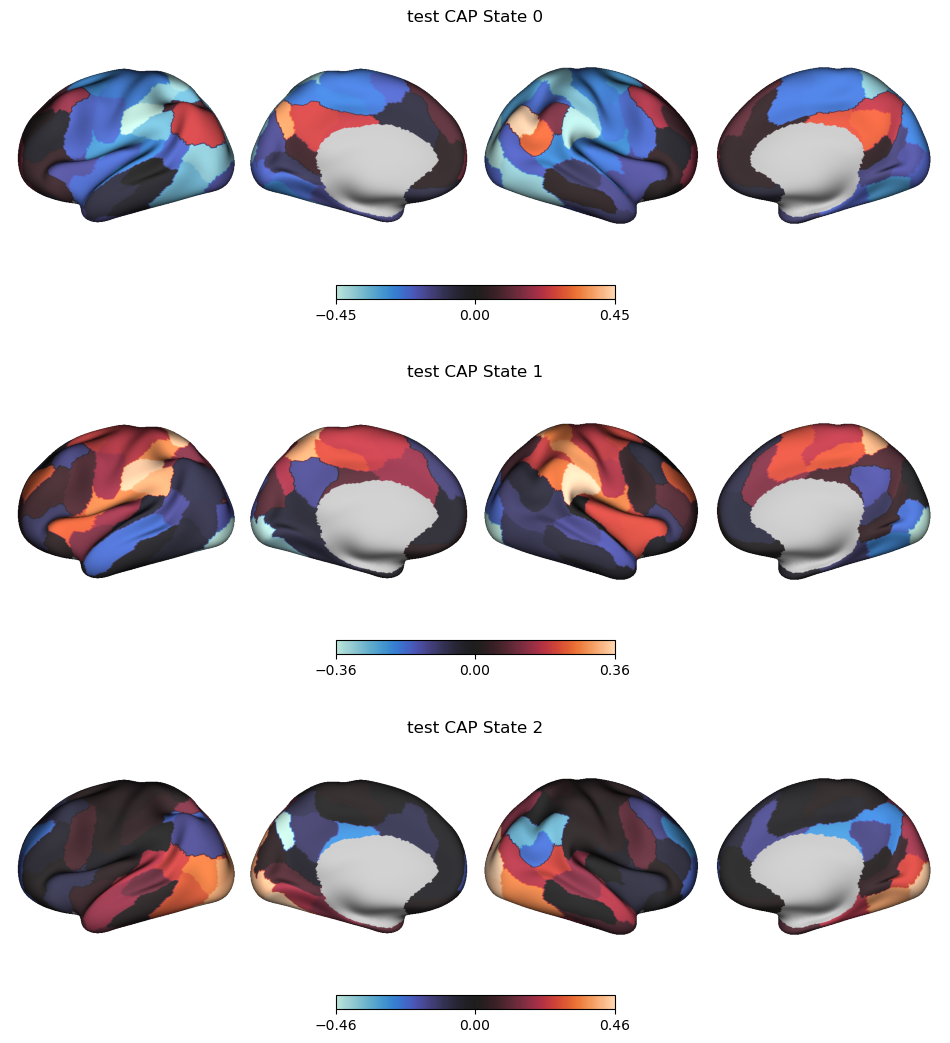

In [11]:
CAP_utils.write_CAP_scalars(CAP_states, save_paths["CAP_pscalar"], cifti=template_cifti)
# TODO: Create plotting functions for CAP states
CAP_plots.create_CAP_state_plots(CAP_states, CAP_labels, ROI_labels, template_cifti,
                                 save_path=save_paths["pCAP_plot"], title=args.title)

# Optional dtseries plots + dscalar

Creating CAP State dscalars:   0%|          | 0/10 [00:00<?, ?it/s]

Writing CAP dscalar.nii: Done 


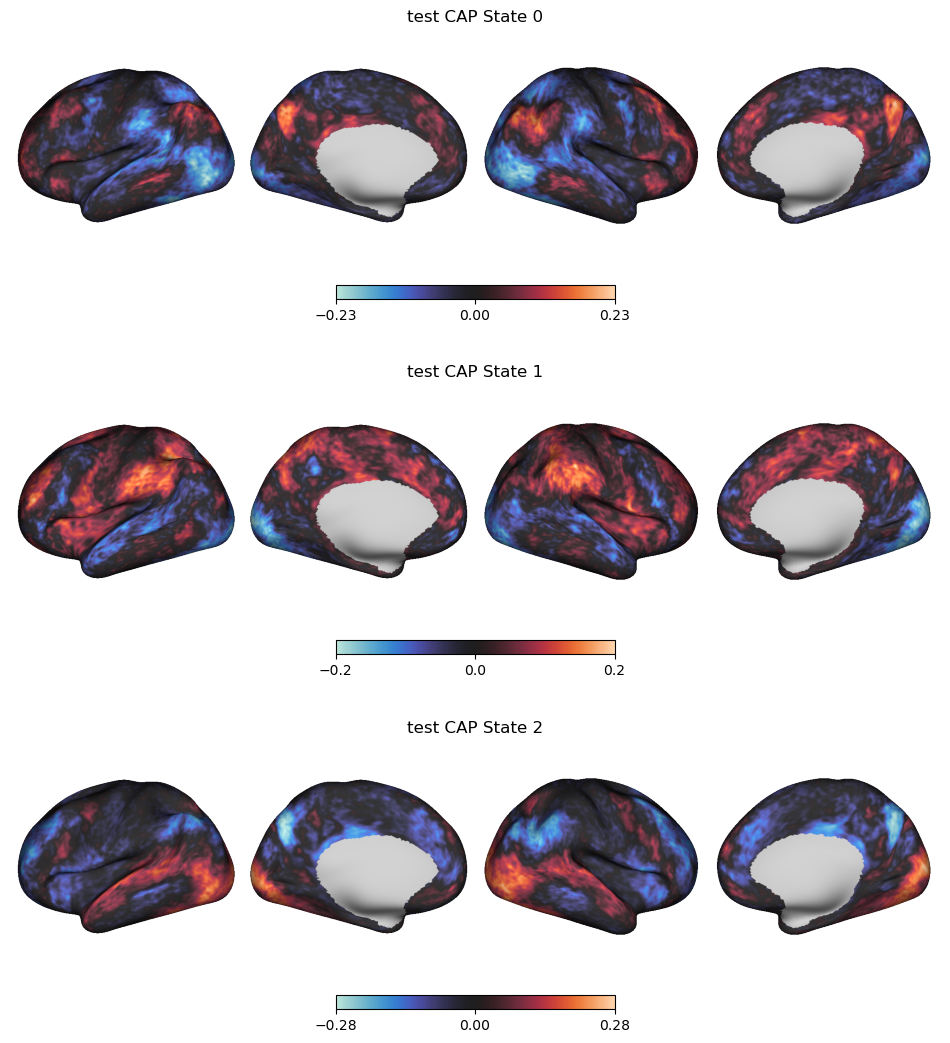

In [12]:
if args.dtseries:
    dtseries_paths = get_cifti_paths(args.dtseries)

    template_dtseries = nb.load(dtseries_paths[0])
    dCAP_states = create_dCAP_states(cifti_array, CAP_labels, dtseries_paths)
    CAP_utils.write_CAP_scalars(dCAP_states, save_paths["CAP_dscalar"], cifti=template_dtseries)
    # TODO: Create plotting functions for CAP states
    CAP_plots.create_CAP_state_plots(dCAP_states, CAP_labels, ROI_labels, template_dtseries,
                                     save_path=save_paths["dCAP_plot"], title=args.title)